# East coast floods


In [1]:
import os
import datetime
import glob

from collections import Counter
import calendar
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy
import cartopy.crs as ccrs
import geopandas as gp
from IPython.display import Image
from scipy.stats import genextreme as gev
import xclim as xc
import cmocean
import seaborn as sns

from unseen import fileio
from unseen import general_utils
from unseen import time_utils
from unseen import indices
from unseen import stability

In [2]:
# Optional parameters 
# (This cell is tagged "parameters")
dpi = 300

In [3]:
# Parameters
agcd_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_AGCD-CSIRO_r005_1900-2022_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
model_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_NorCPM1-dcppA-hindcast_196010-201810_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
model_add_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_NorCPM1-dcppA-hindcast_196010-201810_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-additive.zarr.zip"
model_mulc_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_NorCPM1-dcppA-hindcast_196010-201810_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_add_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_NorCPM1-dcppA-hindcast_1960-2018_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-additive.zarr.zip"
similarity_mulc_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_NorCPM1-dcppA-hindcast_1960-2018_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_raw_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_NorCPM1-dcppA-hindcast_1960-2018_annual-aug-to-sep_east-coast-flood-region_AGCD-CSIRO.zarr.zip"
independence_plot = "/g/data/xv83/dbi599/east-coast-rain/figures/independence-test_Rx15day_NorCPM1-dcppA-hindcast_196010-201810_annual-aug-to-sep_east-coast-flood-region.png"
stability_plot_empirical = "/g/data/xv83/dbi599/east-coast-rain/figures/stability-test-empirical_Rx15day_NorCPM1-dcppA-hindcast_196010-201810_annual-aug-to-sep_east-coast-flood-region.png"
stability_plot_gev = "/g/data/xv83/dbi599/east-coast-rain/figures/stability-test-gev_Rx15day_NorCPM1-dcppA-hindcast_196010-201810_annual-aug-to-sep_east-coast-flood-region.png"
model_name = "NorCPM1"
min_lead = 2
region_name = "east-coast-flood-region"
shape_file = "/g/data/xv83/dbi599/east-coast-rain/shapefiles/east-coast-flood.shp"
file_list = (
    "/home/599/dbi599/east-coast-rain/file_lists/NorCPM1_dcppA-hindcast_pr_files.txt"
)
nino_file = "/g/data/xv83/dbi599/east-coast-rain/data/nino34-anomaly_NorCPM1-dcppA-hindcast_196010-201810_base-1960-2018.nc"


In [4]:
# Required parameters
assert 'model_name' in locals(), "Must provide a model name"
assert 'region_name' in locals(), "Must provide a region name"
assert 'min_lead' in locals(), "Must provide a minimum lead time"
assert os.path.isfile(file_list), "Must provide the input model files list (papermill option -p file_list [filepath])"
assert os.path.isfile(shape_file), "Must provide the shapefile (papermill option -p shape_file [filepath])"
assert os.path.isfile(agcd_file), "Must provide an AGCD data file (papermill option -p agcd_file [filepath])"
assert os.path.isfile(model_file), "Must provide an model data file (papermill option -p model_file [filepath])"
assert os.path.isfile(model_add_bc_file), "Must provide a model additive bias corrected data file (papermill option -p model_add_bc_file [filepath])"
assert os.path.isfile(model_mulc_bc_file), "Must provide a model multiplicative bias corrected data file (papermill option -p model_mulc_bc_file [filepath])"
assert os.path.isfile(nino_file), "Must provide a model Nino 3.4 data file (papermill option -p nino_file [filepath])"
assert os.path.isfile(similarity_add_bc_file), "Must provide an additive bias corrected similarity test file (papermill option -p similarity_add_bias_file [filepath])"
assert os.path.isfile(similarity_mulc_bc_file), "Must provide an multiplicative bias corrected similarity test file (papermill option -p similarity_mulc_bias_file [filepath])"
assert os.path.isfile(similarity_raw_file), "Must provide an raw data similarity test file (papermill option -p similarity_raw_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"
assert os.path.isfile(stability_plot_empirical), "Must provide an empirical stability test plot (papermill option -p stability_plot_empirical [filepath])"
assert os.path.isfile(stability_plot_gev), "Must provide a GEV stability test plot (papermill option -p stability_plot_gev [filepath])"


## Observations

In [5]:
agcd_ds = fileio.open_dataset(agcd_file)
agcd_ds = agcd_ds.dropna('time')

In [6]:
agcd_ds

<xarray.Dataset>
Dimensions:     (time: 122)
Coordinates:
    event_time  (time) <U28 dask.array<chunksize=(122,), meta=np.ndarray>
  * time        (time) object 1901-01-01 09:00:00 ... 2022-01-01 09:00:00
Data variables:
    pr          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    CDO:                           Climate Data Operators version 1.7.0 (http...
    Conventions:                   CF-1.6
    acknowledgment:                The Australian Government, Bureau of Meteo...
    analysis_components:           total: the gridded accumulation of rainfall.
    bom-cmp-awap_version:          bom-cmp-awap-1.00-89.0.x86_64
    ...                            ...
    summary:                       The daily and monthly rainfall data repres...
    time_coverage_end:             1900-01-01T09:00:00
    time_coverage_start:           1899-12-31T09:00:00
    title:                         Interpolated Rain Gauge Precipitation
    url:                           http://www.bom.gov.au/climate/
    uuid:                          14333ae2-28fe-4cb6-9f00-677adc94f25e

In [7]:
years = agcd_ds['time'].dt.year.values
agcd_df = pd.DataFrame(index=years)
agcd_df['pr'] = agcd_ds['pr'].values

In [8]:
pr2022 = agcd_ds['pr'].values.max()
print(pr2022)

410.43057


## Model ensemble

### Region selection

In [9]:
with open(file_list) as f:
    all_files = f.read()
    first_file = all_files.split('\n', 1)[0]

In [10]:
first_file

'/g/data/oi10/replicas/CMIP6/DCPP/NCC/NorCPM1/dcppA-hindcast/s1960-r1i1p1f1/day/pr/gn/v20191005/pr_day_NorCPM1_dcppA-hindcast_s1960-r1i1p1f1_gn_19601015-19710114.nc'

In [11]:
shapes = gp.read_file(shape_file)

In [12]:
isel_dict = {}
if model_name == 'CAFE':
    isel_dict['ensemble'] = 0
    metadata_file = '/home/599/dbi599/unseen/config/dataset_cafe_daily.yml'
else:
    metadata_file = None

In [13]:
region_ds = fileio.open_dataset(
    first_file,
    metadata_file=metadata_file,
    variables=['pr'],
    lat_bnds=[-40, -20],
    lon_bnds=[140, 160],
    shapefile=shape_file,
    shape_overlap=0.1,
    units={'pr': 'mm day-1'},
    isel=isel_dict,
)

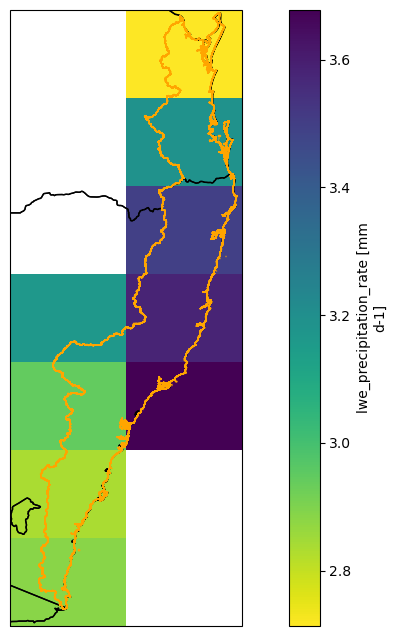

In [14]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
region_ds['pr'].mean('time', keep_attrs=True).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis_r',
)
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.add_geometries(shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='orange')
plt.show()

### Model data

In [15]:
model_ds = fileio.open_dataset(model_file)
model_add_bc_ds = fileio.open_dataset(model_add_bc_file)
model_mulc_bc_ds = fileio.open_dataset(model_mulc_bc_file)

In [16]:
model_ds

<xarray.Dataset>
Dimensions:     (ensemble: 20, init_date: 59, lead_time: 11)
Coordinates:
  * ensemble    (ensemble) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
    event_time  (init_date, ensemble, lead_time) <U28 dask.array<chunksize=(59, 20, 11), meta=np.ndarray>
  * init_date   (init_date) object 1960-10-15 00:00:00 ... 2018-10-15 00:00:00
  * lead_time   (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10
    time        (lead_time, init_date) object dask.array<chunksize=(11, 59), meta=np.ndarray>
Data variables:
    pr          (init_date, ensemble, lead_time) float64 dask.array<chunksize=(1, 1, 11), meta=np.ndarray>
Attributes: (12/51)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               DCPP
    branch_method:             standard
    branch_time:               715308.0
    branch_time_in_child:      715308.0
    branch_time_in_parent:     715308.0
    ...                        ...
    table_id:                  day
    table_info:                Creation Date:(24 July 2019) MD5:0bb394a356ef9...
    title:                     NorCPM1 output prepared for CMIP6
    tracking_id:               hdl:21.14100/4ef66d49-aa8b-4245-af7a-334be80a3fd3
    variable_id:               pr
    variant_label:             r1i1p1f1

### Independence testing

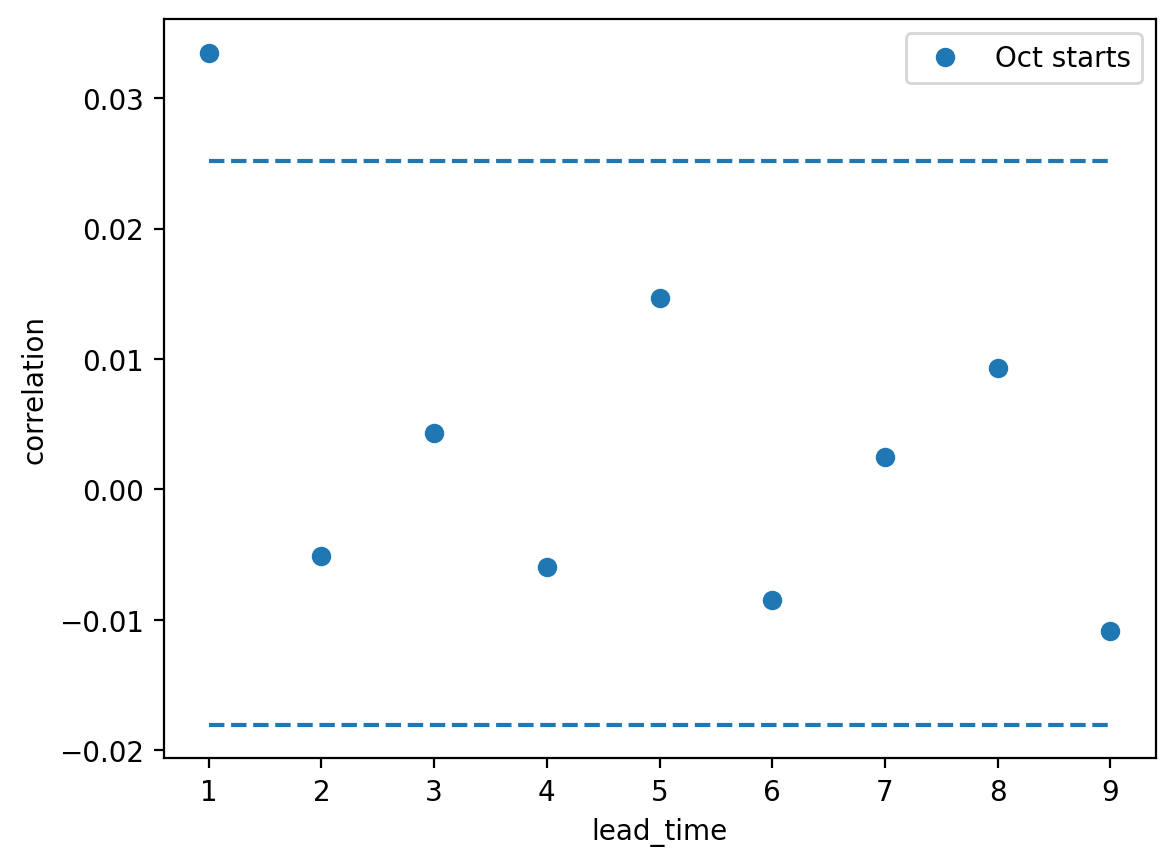

In [17]:
Image(filename=independence_plot)

In [18]:
print(min_lead)

2


In [19]:
model_da = model_ds['pr'].where(model_ds['lead_time'] >= min_lead)

In [20]:
model_da_stacked = model_da.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [21]:
model_da_stacked.shape

(9440,)

In [22]:
model_add_bc_da_stacked = model_add_bc_ds.dropna('lead_time')['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [23]:
model_add_bc_da_stacked.shape

(9440,)

In [24]:
model_mulc_bc_da_stacked = model_mulc_bc_ds.dropna('lead_time')['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [25]:
model_mulc_bc_da_stacked.shape

(9440,)

### Stability analysis

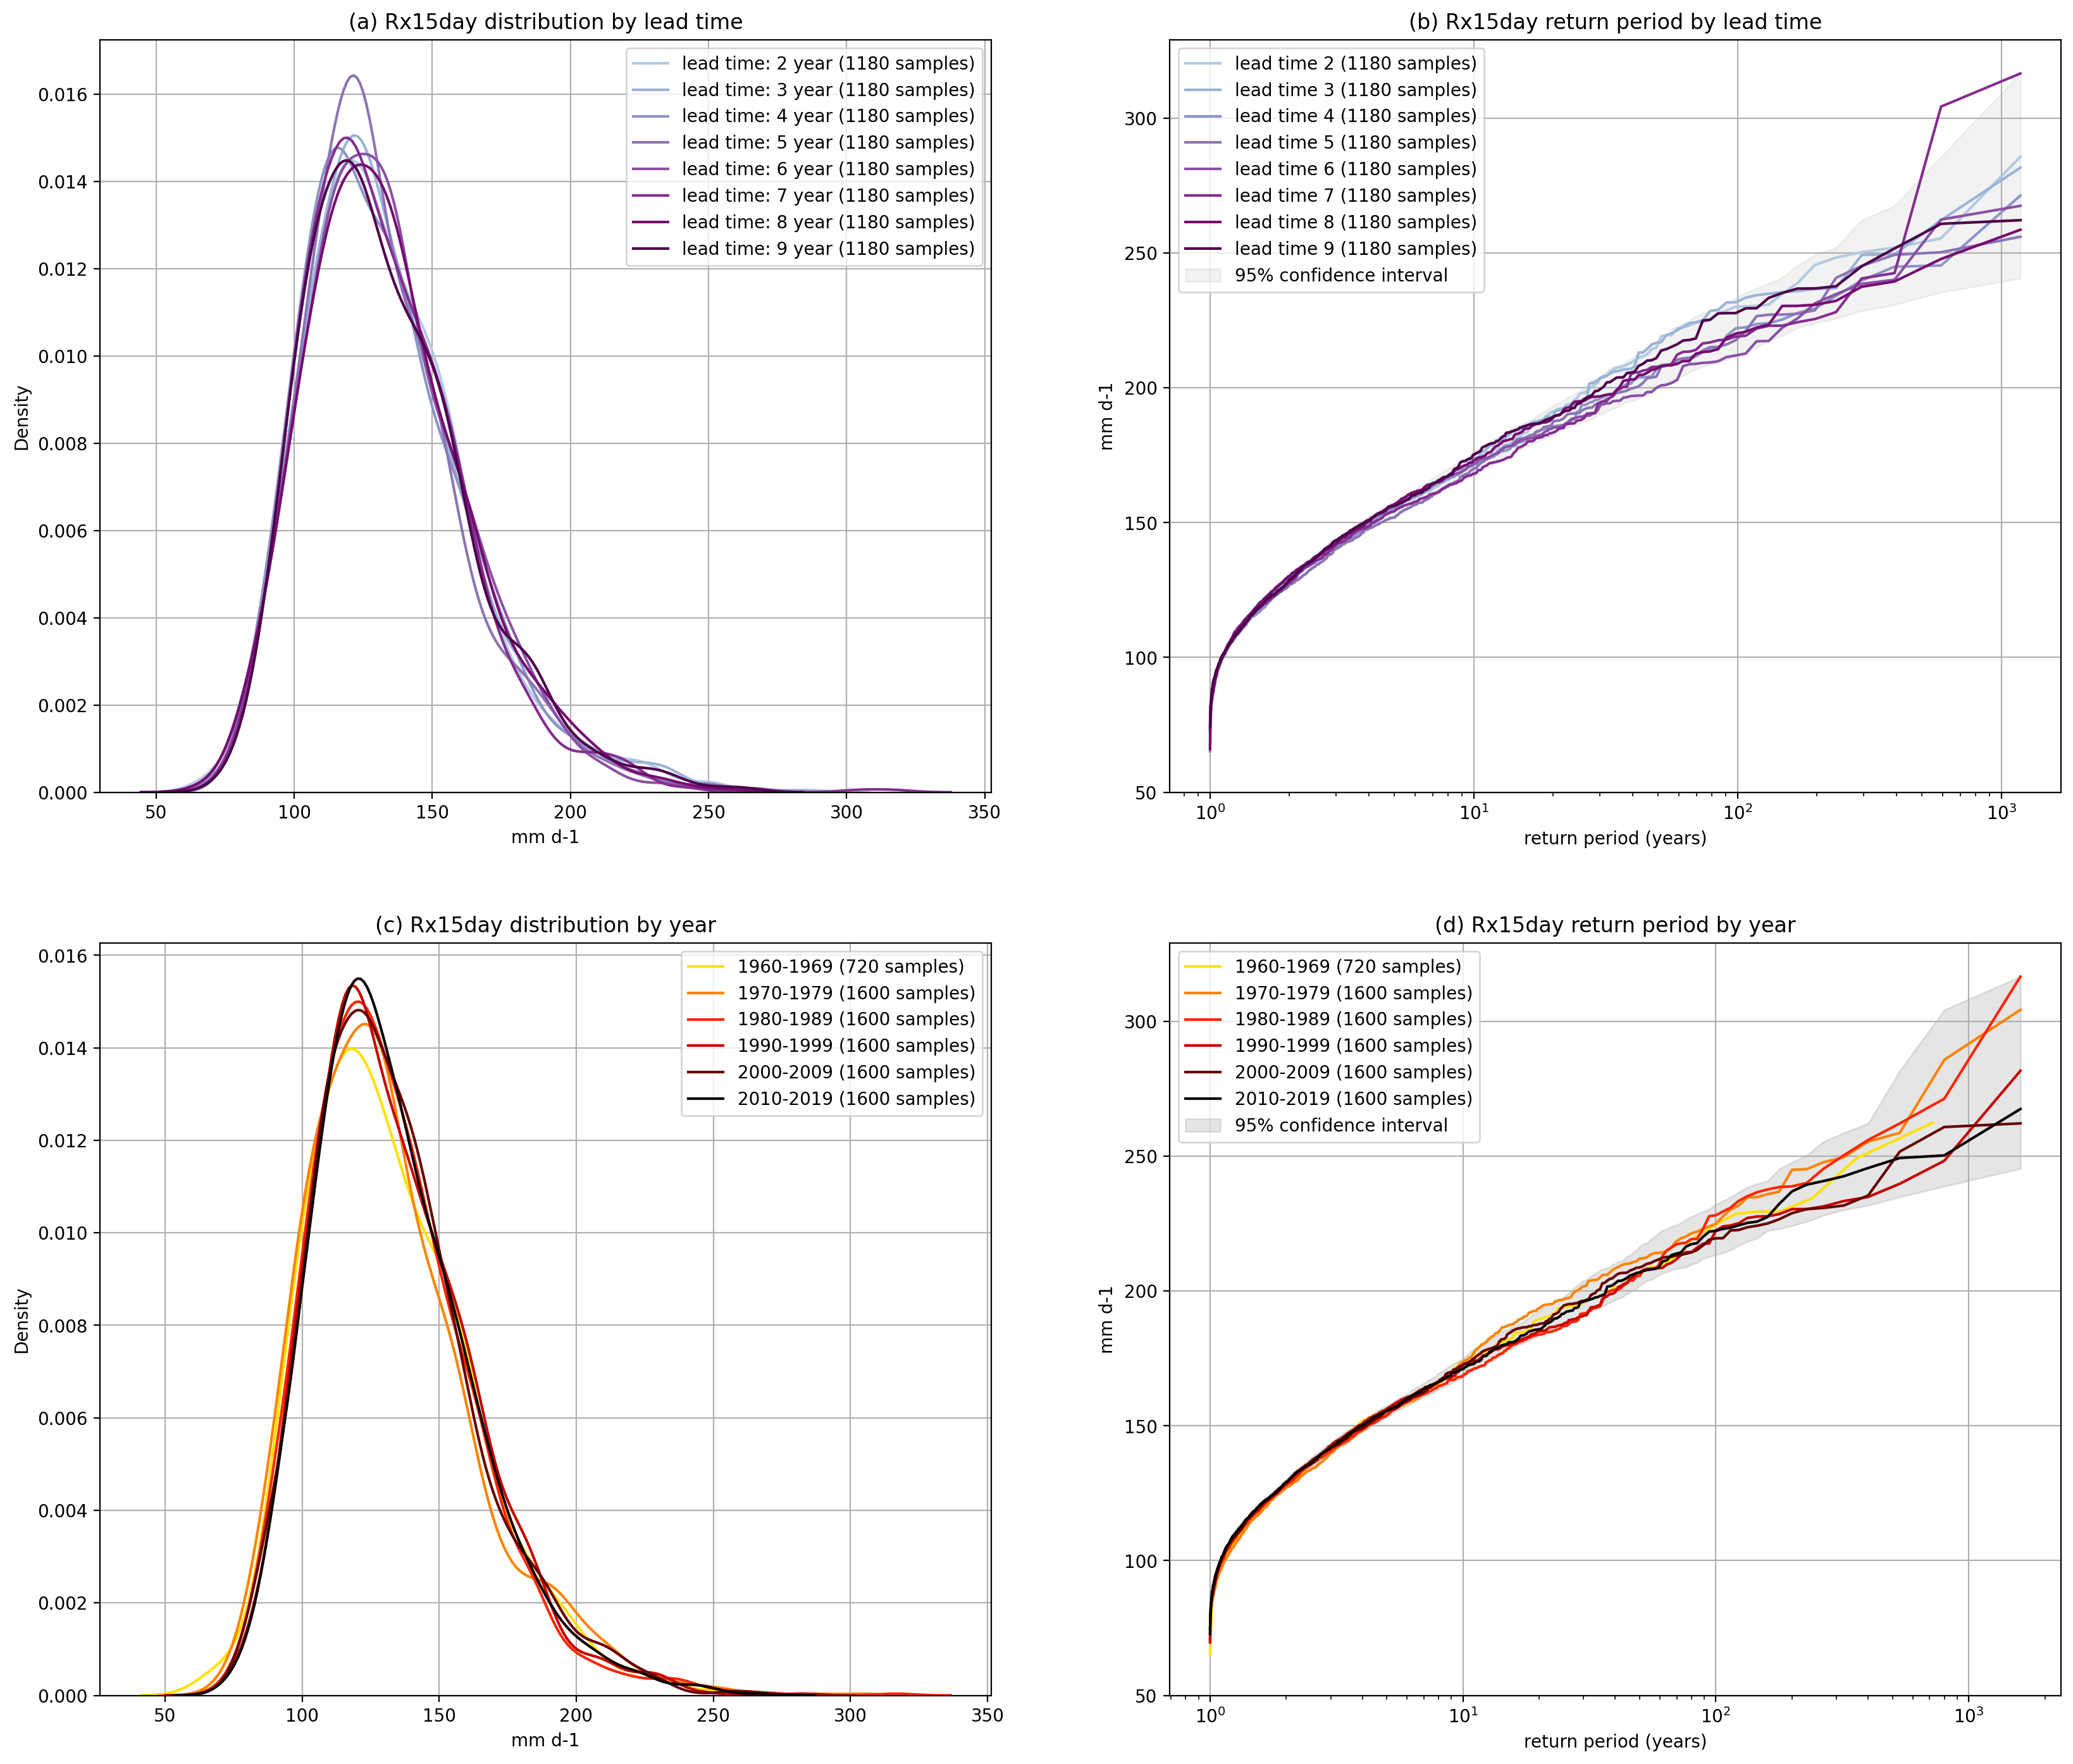

In [26]:
Image(filename=stability_plot_empirical)

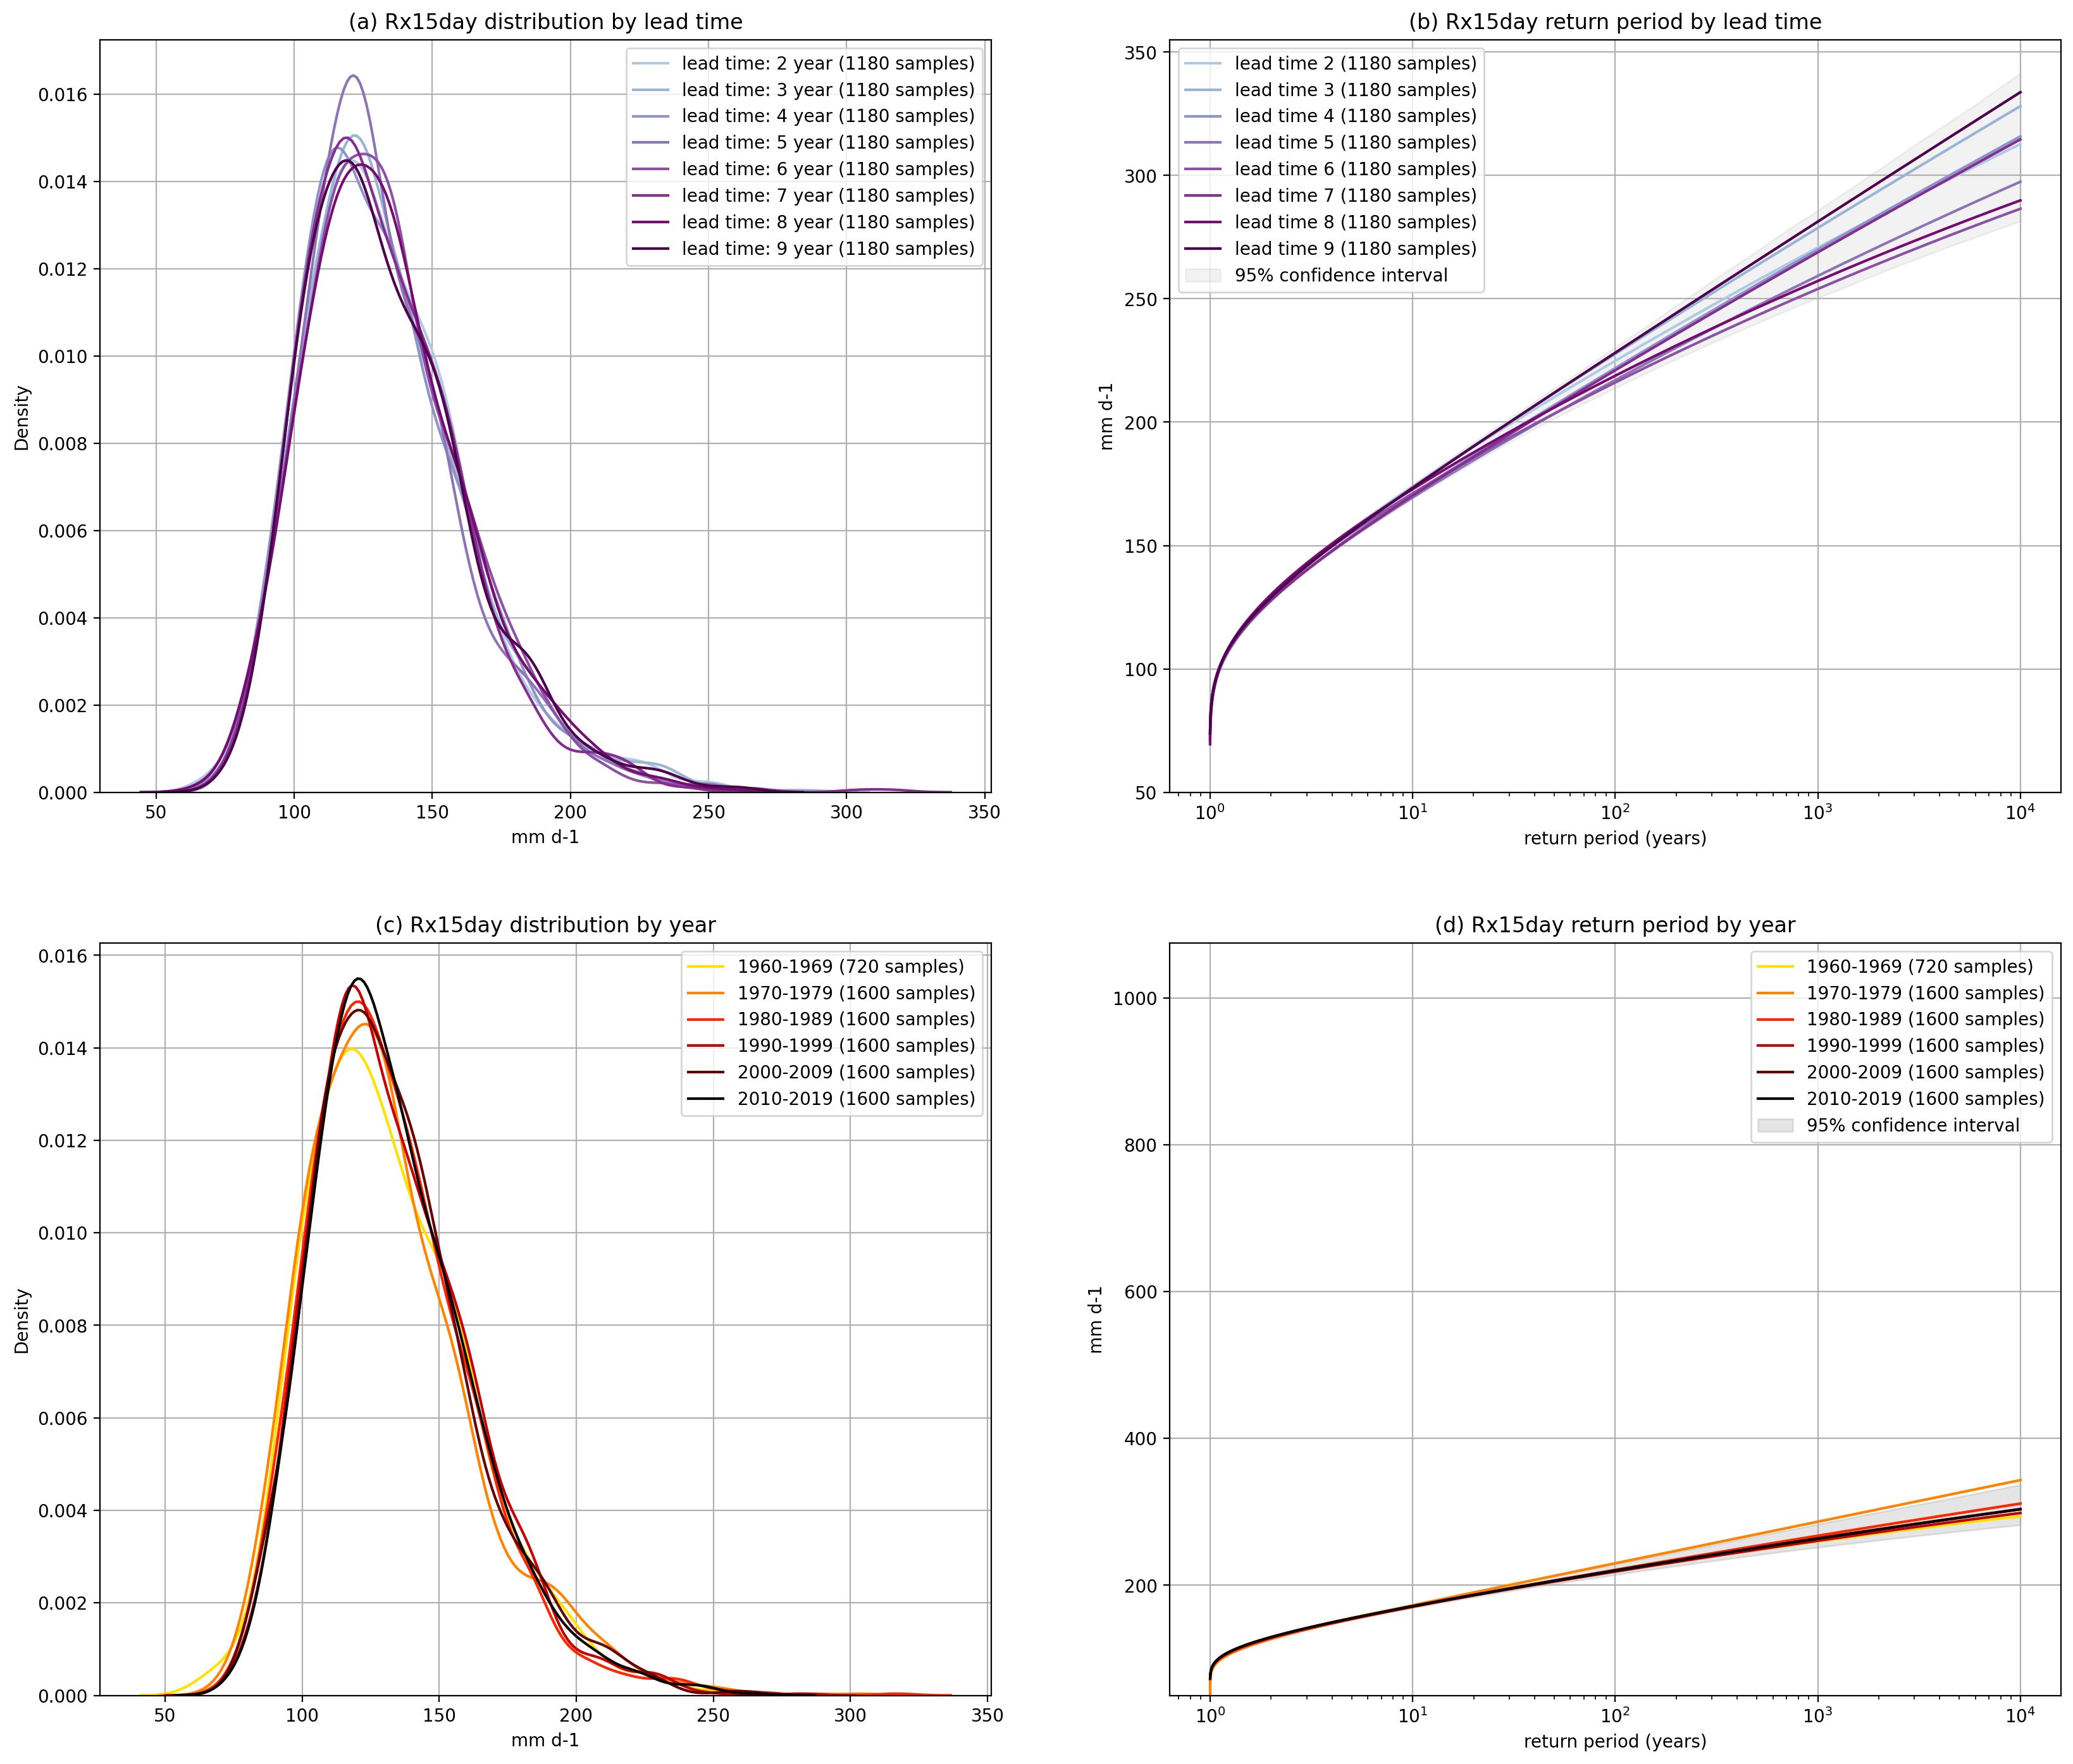

In [27]:
Image(filename=stability_plot_gev)

### Bias correction and similarity testing

In [28]:
model_gev_shape, model_gev_loc, model_gev_scale = indices.fit_gev(model_da_stacked.values)
model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale = indices.fit_gev(model_add_bc_da_stacked.values)
model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale = indices.fit_gev(model_mulc_bc_da_stacked.values)

In [29]:
def plot_distributions(include_additive=False):
    """Plot various distributions"""

    fig = plt.figure(figsize=[10, 6])
    gev_xvals = np.arange(0, 500)

    model_da.plot.hist(
        bins=50, density=True, label=model_name, alpha=0.7, facecolor='tab:blue',
    )
#    model_gev_shape, model_gev_loc, model_gev_scale = indices.fit_gev(model_da_stacked.values, generate_estimates=True)
    model_gev_pdf = gev.pdf(gev_xvals, model_gev_shape, model_gev_loc, model_gev_scale)
    plt.plot(gev_xvals, model_gev_pdf, color='tab:blue', linewidth=4.0)

    if include_additive:
        model_add_bc_ds['pr'].plot.hist(
            bins=50, density=True, label=f'{model_name} additive bias corrected', facecolor='tab:red', alpha=0.7
        )
#        model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale = indices.fit_gev(model_add_bc_da_stacked.values, generate_estimates=True)
        model_add_bc_gev_pdf = gev.pdf(gev_xvals, model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale)
        plt.plot(gev_xvals, model_add_bc_gev_pdf, color='tab:red', linewidth=4.0)

    model_mulc_bc_ds['pr'].plot.hist(
        bins=50, density=True, label=f'{model_name} multiplicative bias corrected', facecolor='tab:orange', alpha=0.7
    )
#    model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale = indices.fit_gev(model_mulc_bc_da_stacked.values, generate_estimates=True)
    model_mulc_bc_gev_pdf = gev.pdf(gev_xvals, model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale)
    plt.plot(gev_xvals, model_mulc_bc_gev_pdf, color='tab:orange', linewidth=4.0)

    agcd_ds['pr'].plot.hist(
        bins=50, density=True, label='AGCD', facecolor='tab:gray', alpha=0.7
    )
    agcd_gev_shape, agcd_gev_loc, agcd_gev_scale = indices.fit_gev(agcd_ds['pr'].values)
    agcd_gev_pdf = gev.pdf(gev_xvals, agcd_gev_shape, agcd_gev_loc, agcd_gev_scale)
    plt.plot(gev_xvals, agcd_gev_pdf, color='tab:gray', linewidth=4.0)

    plt.xlabel('precipitation (mm)')
    plt.ylabel('probability')
    plt.title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    plt.xlim(0, 500)
    plt.legend()
    if not include_additive:
        outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_histogram_{model_name}_{region_name}.png'
        print(outfile)
        plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
    plt.show()

/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_histogram_NorCPM1_east-coast-flood-region.png


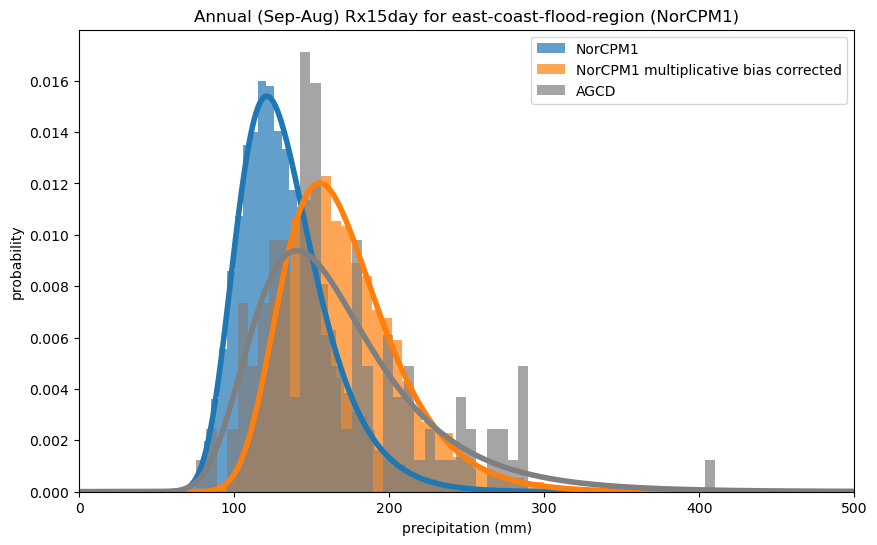

In [30]:
plot_distributions()

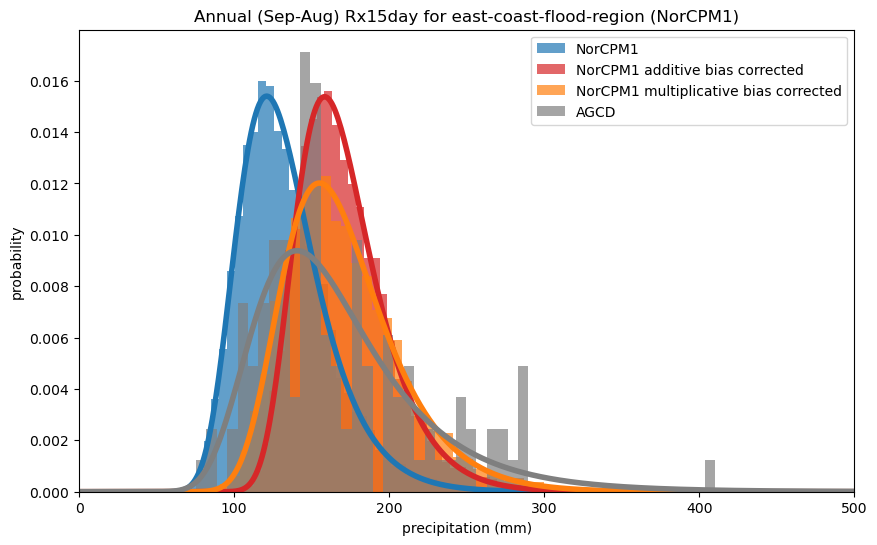

In [31]:
plot_distributions(include_additive=True)

In [32]:
print(f'raw data shape parameter: {model_gev_shape:.3f}')
print(f'raw data location parameter: {model_gev_loc:.3f}') 
print(f'raw data scale parameter: {model_gev_scale:.3f}')

raw data shape parameter: 0.034
raw data location parameter: 120.154
raw data scale parameter: 23.902


In [33]:
print(f'additive corrected shape parameter: {model_add_bc_gev_shape:.3f}')
print(f'additive corrected location parameter: {model_add_bc_gev_loc:.3f}') 
print(f'additive corrected scale parameter: {model_add_bc_gev_scale:.3f}')

additive corrected shape parameter: 0.035
additive corrected location parameter: 157.475
additive corrected scale parameter: 23.937


In [34]:
print(f'multiplicative corrected shape parameter: {model_mulc_bc_gev_shape:.3f}')
print(f'multiplicative corrected location parameter: {model_mulc_bc_gev_loc:.3f}') 
print(f'multiplicative corrected scale parameter: {model_mulc_bc_gev_scale:.3f}')

multiplicative corrected shape parameter: 0.035
multiplicative corrected location parameter: 153.921
multiplicative corrected scale parameter: 30.633


We can look at p-values for the KS-test and Anderson-Darling test for each lead time.

p > 0.05 means the null hypothesis (that the two samples are from the same population) can't be rejected.

In [35]:
similarity_raw_ds = fileio.open_dataset(similarity_raw_file)

In [36]:
similarity_raw_ds['ks_pval'].values

array(3.4275365e-07, dtype=float32)

In [37]:
similarity_raw_ds['ad_pval'].values

array(0.001, dtype=float32)

In [38]:
similarity_add_bias_ds = fileio.open_dataset(similarity_add_bc_file)

In [39]:
similarity_add_bias_ds['ks_pval'].values

array(0.00254028, dtype=float32)

In [40]:
similarity_add_bias_ds['ad_pval'].values

array(0.001, dtype=float32)

In [41]:
similarity_mulc_bias_ds = fileio.open_dataset(similarity_mulc_bc_file)

In [42]:
similarity_mulc_bias_ds['ks_pval'].values

array(0.05076372, dtype=float32)

In [43]:
similarity_mulc_bias_ds['ad_pval'].values

array(0.02268101, dtype=float32)

### Return curves

In [44]:
def gev_event_likelihood(event, shape, loc, scale):
    """Get likelihood stats for an event from a GEV fit"""

    probability = gev.sf(event, shape, loc=loc, scale=scale)
    return_period = 1. / probability
    percentile = (1 - probability) * 100
    print(f'{percentile:.2f}% percentile')
    print(f'{return_period:.0f} year return period\n')

#### Additive bias corrected data

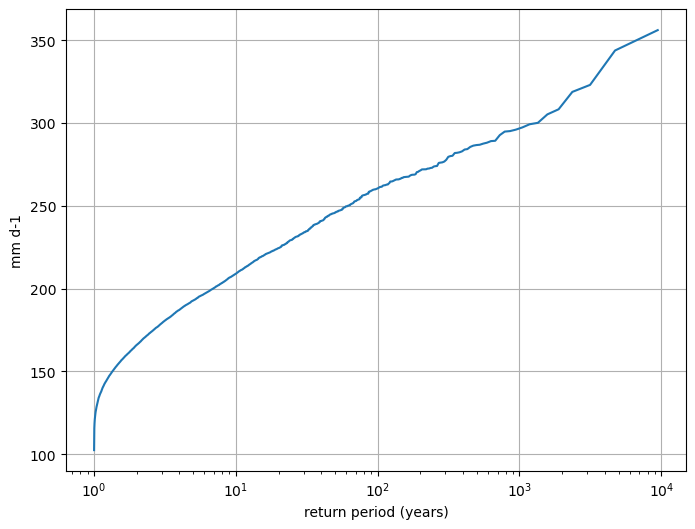

In [45]:
#outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_{region_name}_{model_name}.png'
stability.plot_return(model_add_bc_da_stacked, 'empirical')#, outfile=outfile)

In [46]:
n_events_add_bc, n_population_add_bc, return_period_add_bc, percentile_add_bc = general_utils.event_in_context(model_add_bc_da_stacked.values, pr2022, 'above')
print('ADDITIVE BIAS CORRECTED DATA')
print(f'{n_events_add_bc} events in {n_population_add_bc} samples')
print(f'{percentile_add_bc:.2f}% percentile')
print(f'{return_period_add_bc:.0f} year return period')

ADDITIVE BIAS CORRECTED DATA
0 events in 9440 samples
100.00% percentile
inf year return period


/home/599/dbi599/unseen/unseen/general_utils.py:163: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


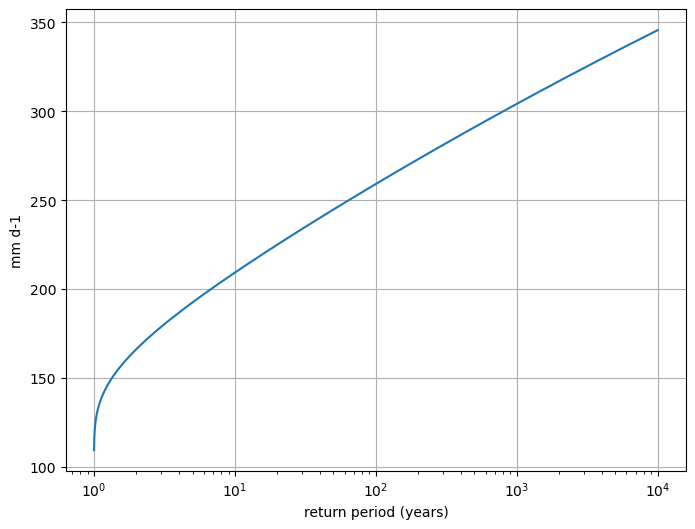

In [47]:
stability.plot_return(model_add_bc_da_stacked, 'gev')

In [48]:
print('ADDITIVE BIAS CORRECTED GEV')
gev_event_likelihood(pr2022, model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale)

ADDITIVE BIAS CORRECTED GEV
100.00% percentile
553831 year return period



#### Multiplicative bias corrected data

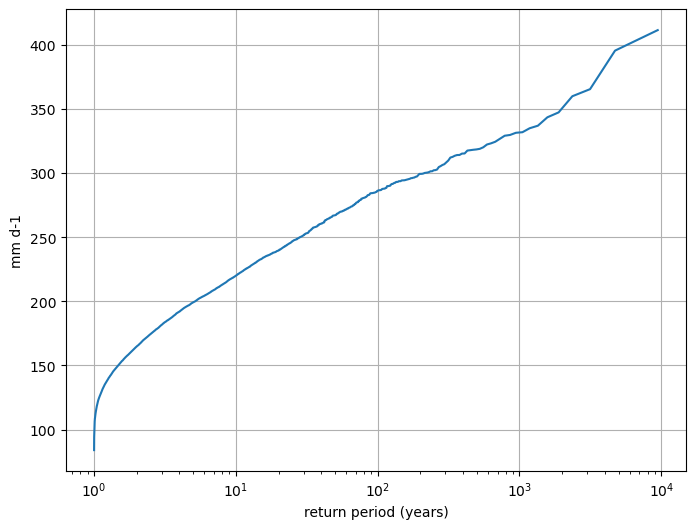

In [49]:
stability.plot_return(model_mulc_bc_da_stacked, 'empirical')

In [50]:
n_events_mulc_bc, n_population_mulc_bc, return_period_mulc_bc, percentile_mulc_bc = general_utils.event_in_context(model_add_bc_da_stacked.values, pr2022, 'above')
print('MULTIPLICATIVE BIAS CORRECTED DATA')
print(f'{n_events_mulc_bc} events in {n_population_mulc_bc} samples')
print(f'{percentile_mulc_bc:.2f}% percentile')
print(f'{return_period_mulc_bc:.0f} year return period')

MULTIPLICATIVE BIAS CORRECTED DATA
0 events in 9440 samples
100.00% percentile
inf year return period


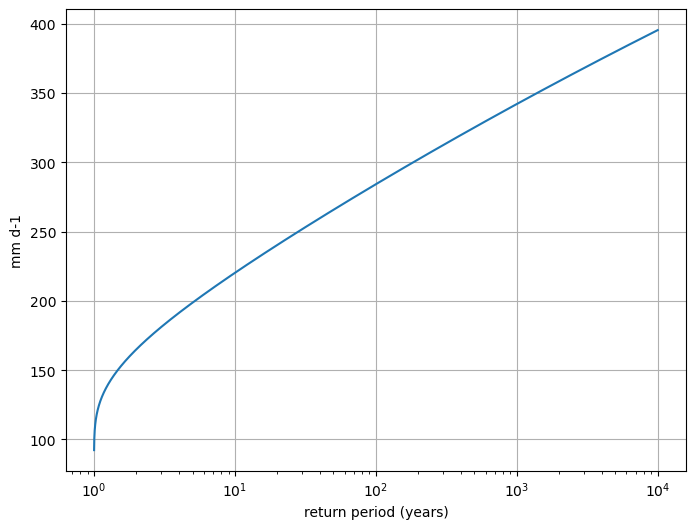

In [51]:
stability.plot_return(model_mulc_bc_da_stacked, 'gev')

In [52]:
print('MULTIPLICATIVE BIAS CORRECTED GEV')
gev_event_likelihood(pr2022, model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale)

MULTIPLICATIVE BIAS CORRECTED GEV
99.99% percentile
19881 year return period



#### Raw data

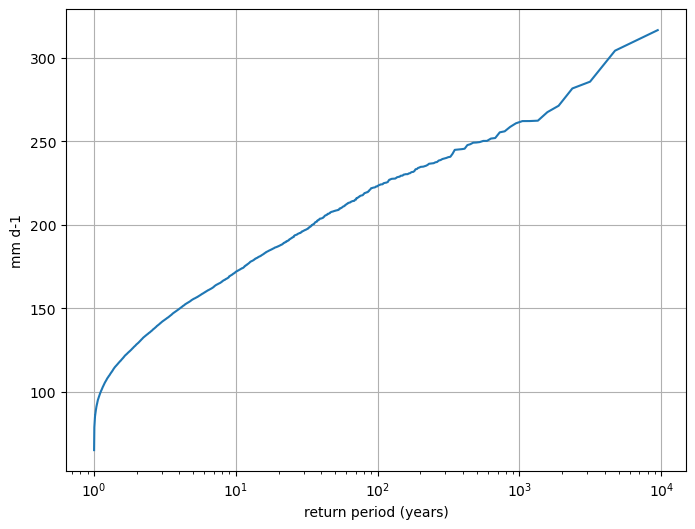

In [53]:
stability.plot_return(model_da_stacked, 'empirical')

In [54]:
n_events, n_population, return_period, percentile = general_utils.event_in_context(model_da_stacked.values, pr2022, 'above')
print('RAW DATA')
print(f'{n_events} events in {n_population} samples')
print(f'{percentile:.2f}% percentile')
print(f'{return_period:.0f} year return period')

RAW DATA
0 events in 9440 samples
100.00% percentile
inf year return period


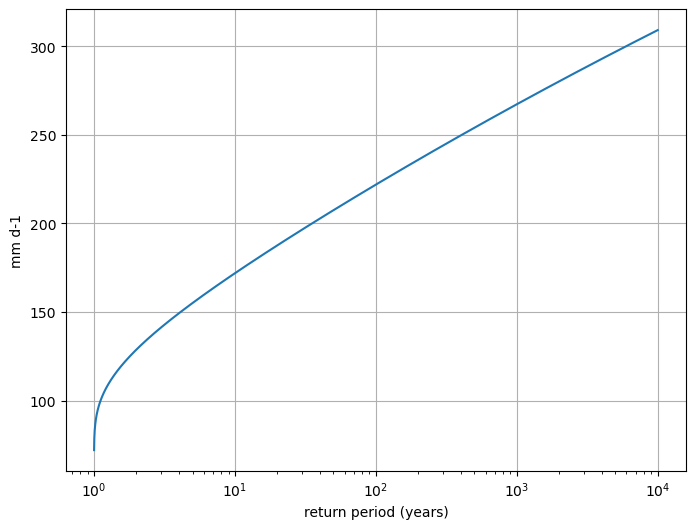

In [55]:
stability.plot_return(model_da_stacked, 'gev')

In [56]:
print('RAW GEV')
gev_event_likelihood(pr2022, model_gev_shape, model_gev_loc, model_gev_scale)

RAW GEV
100.00% percentile
6428396 year return period



### Seasonality

In [49]:
model_df = model_da_stacked.to_dataframe()
model_df = model_df.dropna()

In [50]:
event_months = [int(date[5:7]) for date in model_df['event_time'].values]
event_years = [int(date[0:4]) for date in model_df['event_time'].values]

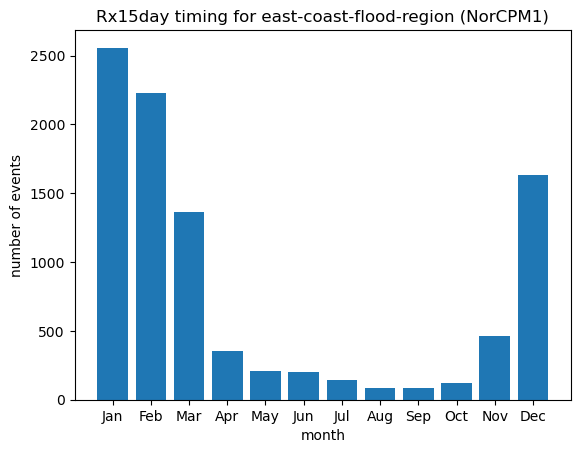

In [51]:
month_counts = Counter(event_months)
months = np.arange(1, 13)
counts = [month_counts[month] for month in months]

plt.bar(months, counts)
plt.title(f'Rx15day timing for {region_name} ({model_name})')
plt.ylabel('number of events')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
#plt.savefig(
#    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timing_AGCD_{region_name}.png',
#    bbox_inches='tight',
#    facecolor='white',
#    dpi=dpi
#)
plt.show()

### Relationship with ENSO

In [58]:
#nino_ds = fileio.open_dataset(nino_file)
#nino_ds = nino_ds.assign_coords({'init_date': [date.strftime('%Y%m') for date in nino_ds['init_date'].values]})
#nino_ds

In [57]:
#nino_values = []
#for index, row in model_df.iterrows():
#    event_init_date = row['init_date'].strftime('%Y%m')
#    event_ensemble = row['ensemble']
#    event_year_month = row['time'].strftime('%Y-%m')
#    nino_selection = nino_ds.sel({'init_date': event_init_date, 'ensemble': event_ensemble})
#    nino_selection = nino_selection.swap_dims({'lead_time': 'time'})
#    nino_year_month = [date.strftime('%Y-%m') for date in nino_selection['time'].values]
#    nino_selection = nino_selection.assign_coords({'time': nino_year_month})
#    nino_value = float(nino_selection['tos'].sel({'time': event_year_month}).values)
#    nino_values.append(nino_value)

In [59]:
#model_df['nino34'] = nino_values

In [60]:
#fig = plt.figure(figsize=[8, 6])
#ax = fig.add_subplot(111)
#
#sns.scatterplot(ax=ax, data=model_df, x='nino34', y='pr')
#sns.kdeplot(ax=ax, data=model_df, x='nino34', y='pr', color='0.9', linewidth=1)
#
#ax.set_ylabel('Rx15day (mm)')
#ax.set_xlabel('Nino 3.4 SST anomaly (C)')
#ax.axvline(0.65)
#ax.axvline(-0.65)
#plt.show()

### Meteorology

In [54]:
def plot_average(start_date, end_date, color_da=None, color_var=None, contour_da=None, contour_var=None):
    """Plot average"""
    
    fig = plt.figure(figsize=[10, 5])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    ax1 = fig.add_subplot(1, 1, 1, projection=map_proj)       
    
    if color_var:
        if color_var == 'pr':
            levels = [0, 100, 200, 300, 400, 500, 600, 700, 800]
            label = 'total precipitation (mm)'
            cmap = cmocean.cm.rain
            extend = 'max'
        elif color_var == 'ua300':
            levels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
            label = '300hPa zonal wind'
            cmap='RdBu_r'
            extend = 'both'
        else:
            raise ValueError('Invalid color variable')
        color_da.plot(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            levels=levels,
            extend=extend,
            cbar_kwargs={'label': label},
        )
    
    if contour_var:
        if contour_var == 'z500':
            levels = np.arange(5000, 6300, 50)
        elif contour_var == 'psl':
            levels = np.arange(900, 1100, 2.5)
        elif contour_var == 'ua300':
            levels = np.arange(15, 60, 5)
        else:
            raise ValueError('Invalid contour variable')
        lines = contour_da.plot.contour(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            levels=levels,
            colors=['0.1']
        )
        ax1.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax1.coastlines()
    ax1.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    ax1.gridlines(linestyle='--', draw_labels=True)
    if contour_var:
        ax1.set_title(f'Average {contour_var} ({contour_da.units}), {start_date} to {end_date}')
    else:
        ax1.set_title(f'{start_date} to {end_date}')
#    plt.savefig(
#        f'/home/599/dbi599/east-coast-rain/{color_var}-{contour_var}_mean_BARRA2_{start_date}_{end_date}.png',
#        bbox_inches='tight',
#        facecolor='white',
#        dpi=300
#    )
    plt.show()

In [55]:
ranked_events = model_df.sort_values(by=['pr'], ascending=False)
ranked_events.head(n=10)

,,,event_time,time,ensemble,init_date,lead_time,pr
ensemble,init_date,lead_time,,,,,,
10,1982-10-15 00:00:00,7,1990-01-09,1989-10-15 12:00:00,10,1982-10-15 00:00:00,7,316.673544
16,1967-10-15 00:00:00,7,1975-02-15,1974-10-15 12:00:00,16,1967-10-15 00:00:00,7,304.370767
0,1972-10-15 00:00:00,2,1975-04-11,1974-10-15 12:00:00,0,1972-10-15 00:00:00,2,285.807417
11,1996-10-15 00:00:00,3,2000-01-28,1999-10-15 12:00:00,11,1996-10-15 00:00:00,3,281.745619
2,1981-10-15 00:00:00,4,1986-02-25,1985-10-15 12:00:00,2,1981-10-15 00:00:00,4,271.387407
19,2008-10-15 00:00:00,6,2015-02-16,2014-10-15 12:00:00,19,2008-10-15 00:00:00,6,267.562011
5,1961-10-15 00:00:00,6,1968-03-21,1967-10-15 12:00:00,5,1961-10-15 00:00:00,6,262.456248
0,1999-10-15 00:00:00,9,2009-01-26,2008-10-15 12:00:00,0,1999-10-15 00:00:00,9,262.228209
11,1981-10-15 00:00:00,3,1985-02-14,1984-10-15 12:00:00,11,1981-10-15 00:00:00,3,262.207289


In [56]:
model_add_bc_df = model_add_bc_ds['pr'].to_dataframe()
model_add_bc_df = model_add_bc_df.dropna()
model_add_bc_df = model_add_bc_df.reset_index()
ranked_add_bc_events = model_add_bc_df.sort_values(by=['pr'], ascending=False)
ranked_add_bc_events.head(n=10)

,init_date,ensemble,lead_time,event_time,time,pr
3605,1982-10-15 00:00:00,10,7,1990-01-09,1989-10-15 12:00:00,356.086280
1253,1967-10-15 00:00:00,16,7,1975-02-15,1974-10-15 12:00:00,343.783503
1920,1972-10-15 00:00:00,0,2,1975-04-11,1974-10-15 12:00:00,323.010685
5849,1996-10-15 00:00:00,11,3,2000-01-28,1999-10-15 12:00:00,318.788652
3378,1981-10-15 00:00:00,2,4,1986-02-25,1985-10-15 12:00:00,308.290183
7836,2008-10-15 00:00:00,19,6,2015-02-16,2014-10-15 12:00:00,305.215868
204,1961-10-15 00:00:00,5,6,1968-03-21,1967-10-15 12:00:00,300.110106
3449,1981-10-15 00:00:00,11,3,1985-02-14,1984-10-15 12:00:00,299.250322
6247,1999-10-15 00:00:00,0,9,2009-01-26,2008-10-15 12:00:00,297.352062
5967,1997-10-15 00:00:00,5,9,2007-02-06,2006-10-15 12:00:00,296.007925


In [57]:
model_mulc_bc_df = model_mulc_bc_ds['pr'].to_dataframe()
model_mulc_bc_df = model_mulc_bc_df.dropna()
model_mulc_bc_df = model_mulc_bc_df.reset_index()
ranked_mulc_bc_events = model_mulc_bc_df.sort_values(by=['pr'], ascending=False)
ranked_mulc_bc_events.head(n=10)

,init_date,ensemble,lead_time,event_time,time,pr
3605,1982-10-15 00:00:00,10,7,1990-01-09,1989-10-15 12:00:00,411.326063
1253,1967-10-15 00:00:00,16,7,1975-02-15,1974-10-15 12:00:00,395.346033
1920,1972-10-15 00:00:00,0,2,1975-04-11,1974-10-15 12:00:00,365.327689
5849,1996-10-15 00:00:00,11,3,2000-01-28,1999-10-15 12:00:00,359.806173
3378,1981-10-15 00:00:00,2,4,1986-02-25,1985-10-15 12:00:00,347.206496
7836,2008-10-15 00:00:00,19,6,2015-02-16,2014-10-15 12:00:00,343.392189
204,1961-10-15 00:00:00,5,6,1968-03-21,1967-10-15 12:00:00,336.839394
3449,1981-10-15 00:00:00,11,3,1985-02-14,1984-10-15 12:00:00,334.854545
3003,1978-10-15 00:00:00,15,5,1984-01-21,1983-10-15 12:00:00,331.759762
6247,1999-10-15 00:00:00,0,9,2009-01-26,2008-10-15 12:00:00,331.326910


1982 (1990-01-09), ensemble: r1i2, 316.6735438073152mm


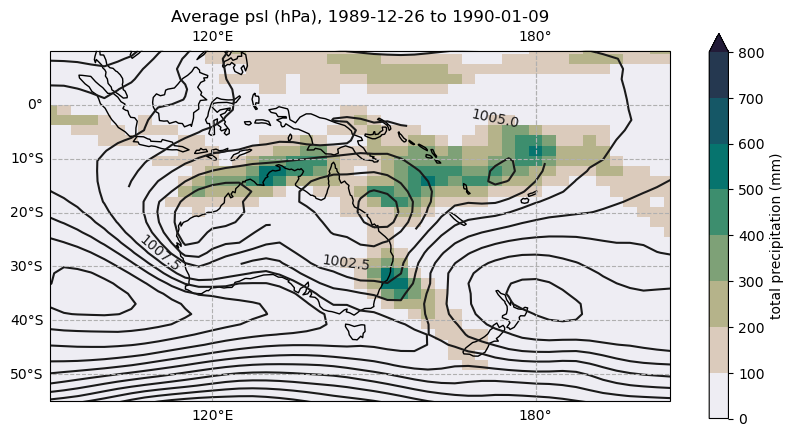

1967 (1975-02-15), ensemble: r7i2, 304.3707667202602mm


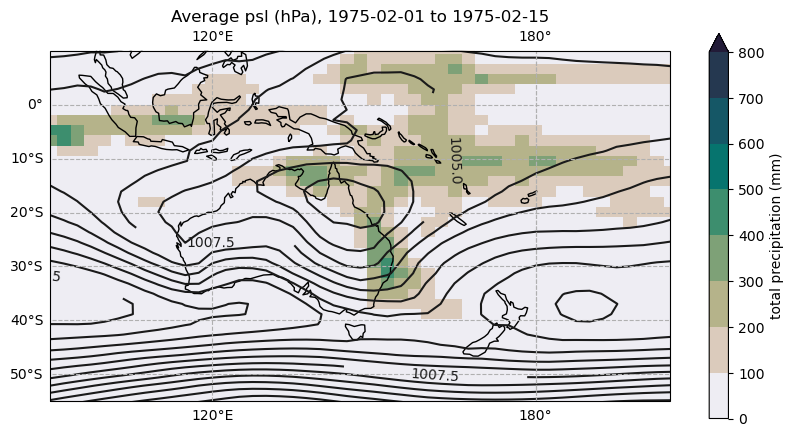

1972 (1975-04-11), ensemble: r1i1, 285.80741650280146mm


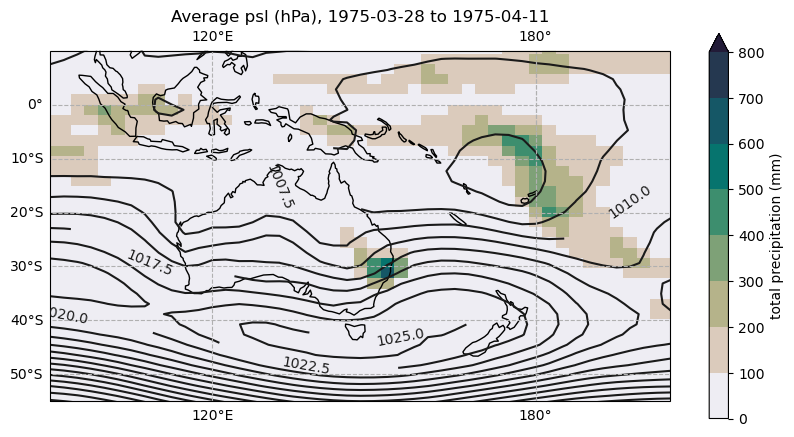

1996 (2000-01-28), ensemble: r2i2, 281.7456193202914mm


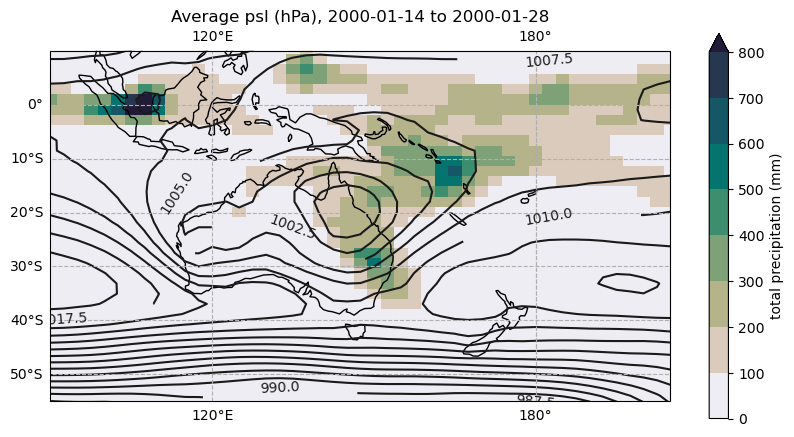

In [59]:
for index, row in ranked_events.head(n=4).iterrows():
    init_date = int(row['init_date'].strftime('%Y'))
    ensemble = int(row['ensemble']) + 1
    if ensemble > 10:
        ensemble = ensemble - 10
        init = 2
    else:
        init = 1
    end_date = row['event_time']
    rx_value = row['pr']
    print(f'{init_date} ({end_date}), ensemble: r{ensemble}i{init}, {rx_value}mm')
    
    start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
    start_date = start_datetime.strftime("%Y-%m-%d")
    
    pr_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i{init}p1f1/day/pr/*/*/*.nc')
    pr_files.sort()
    ds_pr = fileio.open_dataset(pr_files, variables=['pr'],)
    
    psl_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i{init}p1f1/day/psl/*/*/*.nc')
    psl_files.sort()
    ds_psl = fileio.open_dataset(psl_files, variables=['psl'],)
    
#    zg_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/zg/*/*/*.nc')
#    zg_files.sort()
#    ds_zg = fileio.open_dataset(zg_files, variables=['zg'],)
    
#    ua_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/ua/*/*/*.nc')
#    ua_files.sort()
#    ds_ua = fileio.open_dataset(ua_files, variables=['ua'],)

    pr_da = ds_pr.sel({'time': slice(start_date, end_date)})['pr']
    pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
    psl_da = ds_psl.sel({'time': slice(start_date, end_date)})['psl']
    psl_da = xc.units.convert_units_to(psl_da, 'hPa')
#    zg_da = ds_zg.sel({'time': slice(start_date, end_date)})['zg']
#    z500_da = zg_da.sel({'plev': 50000}, method='nearest')
#    ua_da = ds_ua.sel({'time': slice(start_date, end_date)})['ua']
#    ua300_da = ua_da.sel({'plev': 30000}, method='nearest')

    pr_da_sum = pr_da.sum('time', keep_attrs=True)
    psl_da_mean = psl_da.mean('time', keep_attrs=True)
#    z500_da_mean = z500_da.mean('time', keep_attrs=True)
#    ua300_da_mean = ua300_da.mean('time', keep_attrs=True) 

    plot_average(start_date, end_date, pr_da_sum, 'pr', psl_da_mean, 'psl')
#    plot_average(start_date, end_date, pr_da_sum, 'pr', z500_da_mean, 'z500')
#    plot_average(start_date, end_date, ua300_da_mean, 'ua300', z500_da_mean, 'z500')